In [1]:
%matplotlib notebook
#%matplotlib inline
# standard imports 
from __future__ import division 
from __future__ import print_function 
import matplotlib.pyplot as plt 
import numpy as np 
import os 
from glob import glob 
from sunpy.net import Fido, attrs
from datetime import datetime, timedelta
import astropy.units as u 
import sunpy.map as smap 
from astropy.coordinates import SkyCoord 
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel
from datetime import datetime, timedelta
import matplotlib.dates as mdates 
import pickle

In [2]:
import AIA_tools as at

In [3]:
help(at.simulation)

Help on module AIA_tools.simulation in AIA_tools:

NAME
    AIA_tools.simulation

FILE
    /data/khnum/REU2018/jwaczak/cme_shocks/AIA_tools/simulation.py

FUNCTIONS
    getCoronalAbundances(pathToAbund='/data/khnum/REU2018/jwaczak/data/CHIANTI_8.0.7_database/abundance/sun_coronal_1992_feldman.abund')
    
    getEmissData(pathToSavFile)
    
    getEmissList(pathToSavFiles)
    
    getSimulationData(dotDatFile)
    
    getSyntheticObservation(timeIndex, te_sta, te_end, n, simDataFile)
    
    getSyntheticObservation_II(te_sta, te_end, n, simDataFile, nproc)
    
    mp_wrapper(inp)
    
    run(te_sta=1000000.0, te_end=2800000.0, n=10000000.0, num=2, indices='2, 26', ntime=10, dt=0.75, filename='nei_onestep.dat', outputPath='/data/khnum/REU2018/jwaczak/data/simRuns', pathToSimCode='/data/khnum/REU2018/jwaczak/time_dependent_fortran/Applications/NEI_Onestep', pathToChianti="'/data/khnum/REU2018/jwaczak/time_dependent_fortran/eigendata/chianti_8_07/'")
    
    runParallel(simDataFile

In [4]:
pickles = glob('./*.pickle')
print(pickles) 
pickles = {'boxInfo':pickles[0], 'intensities':pickles[1], 'times':pickles[2]}
print(pickles)

['./boxInfo_MaEtAl.pickle', './intensities_MaEtAl.pickle', './times_MaEtAl.pickle']
{'intensities': './intensities_MaEtAl.pickle', 'boxInfo': './boxInfo_MaEtAl.pickle', 'times': './times_MaEtAl.pickle'}


In [5]:
data = {'boxInfo':None, 'intensities':None, 'times':None}    

for key in data: 
    print(key) 
    file_ = open(pickles[key], 'r') 
    data[key] = pickle.load(file_ ) 

    


intensities
boxInfo
times


** get array of time steps and then create a time axis in seconds ** 

In [6]:
times = {'171':[], '193':[], '211':[], '304':[], '335':[]}

for key in times:
    # start the times at zero seconds and add that to the list 
    tot = 0.0
    times[key].append(tot)
    
    # get difference and add to tot 
    for i in range(1, len(data['times'][key])): 
        t_diffs =(data['times'][key][i]-data['times'][key][i-1]).total_seconds()
        tot += t_diffs
        times[key].append(tot) 

In [7]:
print(times['171'])

[0.0, 12.01, 23.990000000000002, 36.02, 48.0, 60.01, 71.99, 84.02, 95.99, 108.00999999999999, 119.99, 132.01, 143.98999999999998, 156.01999999999998, 167.98999999999998, 180.01, 192.0, 204.02, 215.99, 228.02, 239.99, 252.01000000000002, 264.0, 276.02, 288.0, 300.01, 311.99, 324.02, 335.99, 348.01, 359.99, 372.01, 383.99, 396.01, 408.0, 420.01, 431.99, 444.02, 455.99, 468.01, 480.0, 492.01, 504.0, 516.02, 527.99, 540.01, 551.99, 564.02, 575.99, 588.01, 599.99, 612.01, 623.99, 636.02, 647.99, 660.01, 671.99, 684.02, 695.99, 708.01, 719.99, 732.01, 743.99, 756.02, 767.99, 780.01, 791.99, 804.02, 815.99, 828.01, 839.99, 852.01, 864.0, 876.02, 887.99, 900.01, 912.0, 924.02, 935.99, 948.02, 960.0, 972.01, 983.99, 996.02, 1007.99, 1020.01, 1031.99, 1044.02, 1055.99, 1068.02, 1080.0, 1092.01, 1103.99, 1116.02, 1127.99, 1140.01, 1151.99, 1164.02, 1175.99, 1188.02]


** Plot the observational data ** 

<IPython.core.display.Javascript object>


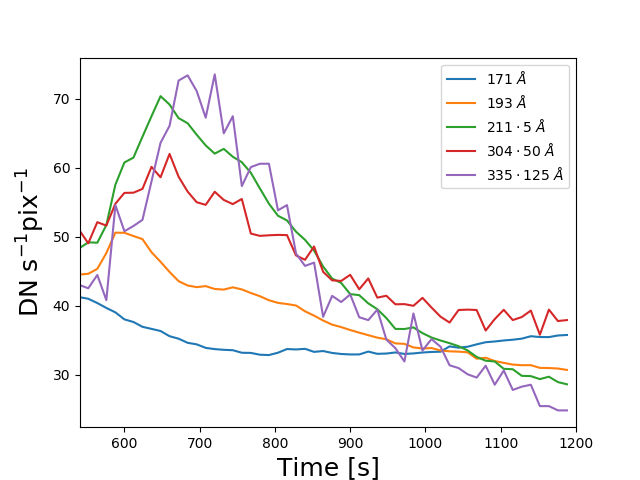

In [8]:
intensities = data['intensities']

fig, ax = plt.subplots() 

ax.plot(times['171'], intensities['171'], label='$171$ $\AA$') 
ax.plot(times['193'], intensities['193'], label='$193$ $\AA$')
ax.plot(times['211'], 5*np.asarray(intensities['211']), label='$211 \cdot 5$ $\AA$')
ax.plot(times['304'], 50*np.asarray(intensities['304']), label='$304 \cdot 50$ $\AA$')
ax.plot(times['335'], 125*np.asarray(intensities['335']), label='$335 \cdot 125$ $\AA$') 
ax.set_ylabel("DN $\mathrm{s}^{-1} \mathrm{pix}^{-1}$", fontsize=18)
ax.set_xlabel("Time [s]", fontsize=18)
ax.set_xlim(541, 1200) 
ax.legend() 

** Now take ratios and plot -- FIXME -- ask how to deal with times for ratio plots (interpolation?) ** 

<IPython.core.display.Javascript object>


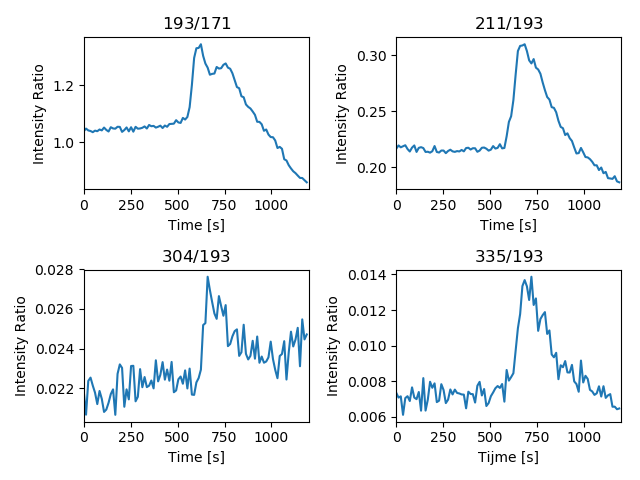

In [9]:
intensities = data['intensities']

fig, ax = plt.subplots(nrows=2, ncols=2) 

ax[0,0].plot(np.mean([times['193'], times['171']], axis=0),
             np.divide(intensities['193'],intensities['171']), label='$193/171$') 
ax[0,1].plot(np.mean([times['211'], times['193']], axis=0),
             np.divide(intensities['211'],intensities['193']), label='$211/193$')
ax[1,0].plot(np.mean([times['304'], times['193']], axis=0),
             np.divide(intensities['304'],intensities['193']), label='$304/193$')
ax[1,1].plot(np.mean([times['335'], times['304']], axis=0),
             np.divide(intensities['335'],intensities['193']), label='$335/193$') 

ax[0,0].set_ylabel("Intensity Ratio")
ax[0,0].set_xlabel("Time [s]")
ax[0,0].set_xlim(0, 1200)
ax[0,0].set_title('$193/171$')

ax[0,1].set_ylabel("Intensity Ratio")
ax[0,1].set_xlabel("Time [s]")
ax[0,1].set_xlim(0, 1200)
ax[0,1].set_title('$211/193$')

ax[1,0].set_ylabel("Intensity Ratio")
ax[1,0].set_xlabel("Time [s]")
ax[1,0].set_xlim(0, 1200)
ax[1,0].set_title('$304/193$')

ax[1,1].set_ylabel("Intensity Ratio")
ax[1,1].set_xlabel("Tijme [s]")
ax[1,1].set_xlim(0, 1200)
ax[1,1].set_title('$335/193$')

plt.tight_layout()
plt.show()


** Now let's try and interpolate the times to be the same ** 

In [10]:
# times go from 540 to 1200 [s] 
# use the 171 A times as that is how we defined the start of the cme 

# create interpolation objects 
interp_171 = interp1d(times['171'], intensities['171'])
interp_193 = interp1d(times['193'], intensities['193']) 
interp_211 = interp1d(times['211'], intensities['211'])
interp_304 = interp1d(times['304'], intensities['304']) 
interp_335 = interp1d(times['335'], intensities['335']) 

# new times 
timeIndex_low = at.analysis.getNearestValue(np.asarray(times['171']), 540)
timeIndex_high = at.analysis.getNearestValue(np.asarray(times['171']), 1100) 
time_vals = times['171'][timeIndex_low:timeIndex_high]
intensities['171'] = intensities['171'][timeIndex_low:timeIndex_high]
intensities['193'] = interp_193(time_vals) 
intensities['211'] = interp_211(time_vals) 
intensities['304'] = interp_304(time_vals) 
intensities['335'] = interp_335(time_vals) 

print(len(time_vals)) 
Dt = np.mean(np.asarray(time_vals)[1:]-np.asarray(time_vals)[0:-1])
print(Dt) 

47
12.0


In [11]:
# trying out temperature from Ma et al. paper 
te_sta = 1e6 
te_end = 2.8e6 
n = 1e7

element_list = '2, 6, 7, 8, 10, 12, 13, 14, 16, 18, 20, 26, 28'  # He, C, N, O, Ne, Mg, Al, Si, S, Ar, Ca, Fe, Ni
simDataFile = at.simulation.run(te_sta, te_end, n, num=13,
               indices=element_list, ntime=len(time_vals), dt=Dt, filename='te_end-1e6__te_sta-2.8e6__n-1e7.dat')

In [13]:
emissList = at.simulation.getEmissList('/data/khnum/REU2018/jwaczak/data/chiantiEmissData')
emissData = at.simulation.getEmissData(emissList[26][14][7])

In [24]:
log_temps = emissData['logte_1d']
real_temps = np.power(10.0, log_temps)
real_temps = real_temps[real_temps>5e6]
print(real_temps.min(), real_temps.max())
np.savetxt('/data/khnum/REU2018/jwaczak/data/tempVals.txt', real_temps, delimiter=',')

5011870.135142811 100000000.0


<IPython.core.display.Javascript object>


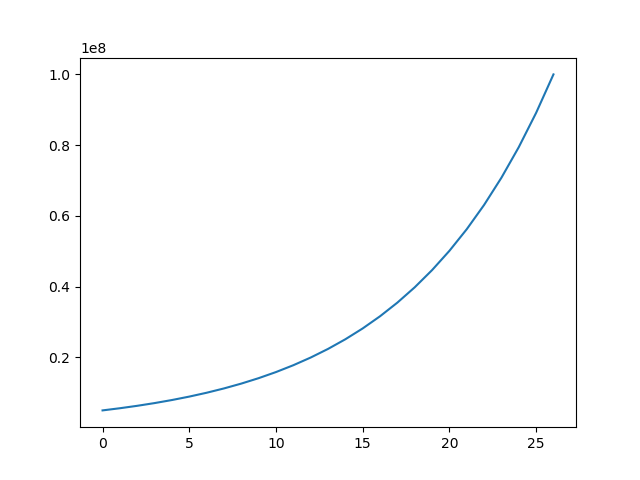

In [23]:
plt.figure()
plt.plot(real_temps) 
plt.show()

In [ ]:
%%time
obs = at.simulation.getSyntheticObservation_II(te_sta, te_end, 7, simDataFile, 3)

In [ ]:
for key in obs.keys(): 
    print(len(obs[key]))

In [ ]:
fig, ax = plt.subplots() 
for key in obs.keys(): 
    if key is not 'time': 
        dat = np.asarray(obs[key]) 
        print(np.shape(dat))
        ax.plot(np.asarray(obs['time']), dat/dat.max())
        
plt.show() 

In [ ]:
from glob import glob 
files = glob('/data/khnum/REU2018/jwaczak/data/simOutput/*.txt')
print(files)



In [ ]:
for file_ in files: 
    data = np.loadtxt(file_, delimiter=',')
    print(np.shape(data))